In [1]:
pip install sentencepiece


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

# Text preprocessing function
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenizing
    words = word_tokenize(text)
    # Removing stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # Joining words back to text
    text = ' '.join(words)
    return text

# Load the dataset
df = pd.read_csv('threshold.csv',nrows=10000)

# Preprocess the labels
df['target'] = df['target'].apply(lambda x: 1 if x.lower() == 'genuine' else 0)

# Apply text preprocessing
df['text'] = df['text'].apply(preprocess_text)

# Use a smaller subset of the dataset for faster prototyping
#df = df.sample(min(500, len(df)))  # Adjust this number based on your dataset size

# Split the data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'], df['target'], test_size=0.2, random_state=42
)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Initialize the tokenizer and model
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

# Parameters
BATCH_SIZE = 8  # Reduced batch size to fit within memory constraints
MAX_LENGTH = 128

# Create the dataset objects
train_dataset = TextDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
test_dataset = TextDataset(test_texts, test_labels, tokenizer, MAX_LENGTH)

# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

# Evaluation function
def eval_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

    accuracy = correct_predictions.double() / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader)
    return accuracy, avg_loss

# Train and evaluate the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

EPOCHS = 3  # Set to 1 epoch for now

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_loss = train_epoch(model, train_dataloader, optimizer, device)
    val_acc, val_loss = eval_model(model, test_dataloader, device)

    print(f'Train loss: {train_loss}, Val loss: {val_loss}, Val accuracy: {val_acc}')

# # Save the model
# model.save_pretrained('xlnet_model')
# tokenizer.save_pretrained('xlnet_model')


[nltk_data] Downloading package punkt to /Users/ravi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ravi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/ravi/.local/pipx/.cache/7b4d30832dadd99/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3


Evaluating: 100%|█████████████████████████████| 250/250 [02:18<00:00,  1.81it/s]


Train loss: 0.5395244425535202, Val loss: 0.5241680791378022, Val accuracy: 0.781
Epoch 2/3


Evaluating: 100%|█████████████████████████████| 250/250 [02:19<00:00,  1.79it/s]


Train loss: 0.5366614621207118, Val loss: 0.5053042377233505, Val accuracy: 0.781
Epoch 3/3


Evaluating: 100%|█████████████████████████████| 250/250 [02:20<00:00,  1.79it/s]

Train loss: 0.5400090370327234, Val loss: 0.5268255231380463, Val accuracy: 0.781


BERT MODEL

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup

# Check if CUDA is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the dataset
df = pd.read_csv('threshold.csv',nrows=10000)

# Convert 'genuine' and 'fake' labels to numerical labels
df['target'] = df['target'].map({'genuine': 1, 'fake': 0})

# Split the dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

# Convert to torch tensors
train_inputs = torch.tensor(train_encodings['input_ids'])
train_masks = torch.tensor(train_encodings['attention_mask'])
train_labels = torch.tensor(train_labels.values)

test_inputs = torch.tensor(test_encodings['input_ids'])
test_masks = torch.tensor(test_encodings['attention_mask'])
test_labels = torch.tensor(test_labels.values)

# Create DataLoader objects with optimization
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32, num_workers=4)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32, num_workers=4)

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

# Define the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * 1  # 1 epoch
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training function
def train_model():
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss}")

# Evaluation function
def evaluate_model():
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, axis=1).tolist())
            true_labels.extend(b_labels.tolist())
    print("Accuracy:", accuracy_score(true_labels, preds))
    print("Classification Report:")
    print(classification_report(true_labels, preds))

# Train and evaluate the model
for epoch in range(3): 
    print(f"Epoch {epoch + 1}")
    train_model()
    evaluate_model()

# # Save the model
# model.save_pretrained('bert_model')
# tokenizer.save_pretrained('bert_model')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1


/Users/ravi/.local/pipx/.cache/7b4d30832dadd99/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


KeyboardInterrupt: 

HUGG

In [ ]:
pip install pandas torch transformers scikit-learn nltk


In [ ]:
pip install --upgrade numpy


In [5]:
pip install matplotlib seaborn scikit-learn tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 5.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 7.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Matplotlib is building the font cache; this may take a moment.
[nltk_data] Downloading package punkt to /Users/ravi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ravi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/ravi/.local/pipx/.cache/7b4d30832dadd99/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.war

Epoch 1


Evaluating: 100%|███████████████████████████████| 63/63 [01:10<00:00,  1.12s/it]


Train loss: 0.4600657765269279, Validation accuracy: 0.8135
Classification Report:
{'0': {'precision': 0.6101694915254238, 'recall': 0.410958904109589, 'f1-score': 0.49113233287858116, 'support': 438.0}, '1': {'precision': 0.8486803519061583, 'recall': 0.9263764404609475, 'f1-score': 0.8858279767370677, 'support': 1562.0}, 'accuracy': 0.8135, 'macro avg': {'precision': 0.7294249217157911, 'recall': 0.6686676722852682, 'f1-score': 0.6884801548078244, 'support': 2000.0}, 'weighted avg': {'precision': 0.7964464734827774, 'recall': 0.8135, 'f1-score': 0.7993896307320592, 'support': 2000.0}}
Epoch 2


Evaluating: 100%|███████████████████████████████| 63/63 [00:59<00:00,  1.06it/s]


Train loss: 0.361717348664999, Validation accuracy: 0.812
Classification Report:
{'0': {'precision': 0.6115107913669064, 'recall': 0.3881278538812785, 'f1-score': 0.4748603351955307, 'support': 438.0}, '1': {'precision': 0.8443670150987224, 'recall': 0.9308578745198464, 'f1-score': 0.8855054811205847, 'support': 1562.0}, 'accuracy': 0.812, 'macro avg': {'precision': 0.7279389032328144, 'recall': 0.6594928642005624, 'f1-score': 0.6801829081580577, 'support': 2000.0}, 'weighted avg': {'precision': 0.7933715021014547, 'recall': 0.812, 'f1-score': 0.7955741941629979, 'support': 2000.0}}
Epoch 3


Evaluating: 100%|███████████████████████████████| 63/63 [01:08<00:00,  1.09s/it]


Train loss: 0.26761433148384095, Validation accuracy: 0.795
Classification Report:
{'0': {'precision': 0.5297872340425532, 'recall': 0.5684931506849316, 'f1-score': 0.5484581497797357, 'support': 438.0}, '1': {'precision': 0.8764705882352941, 'recall': 0.8585147247119078, 'f1-score': 0.8673997412677878, 'support': 1562.0}, 'accuracy': 0.795, 'macro avg': {'precision': 0.7031289111389236, 'recall': 0.7135039376984197, 'f1-score': 0.7079289455237618, 'support': 2000.0}, 'weighted avg': {'precision': 0.8005469336670838, 'recall': 0.795, 'f1-score': 0.7975515327319045, 'support': 2000.0}}


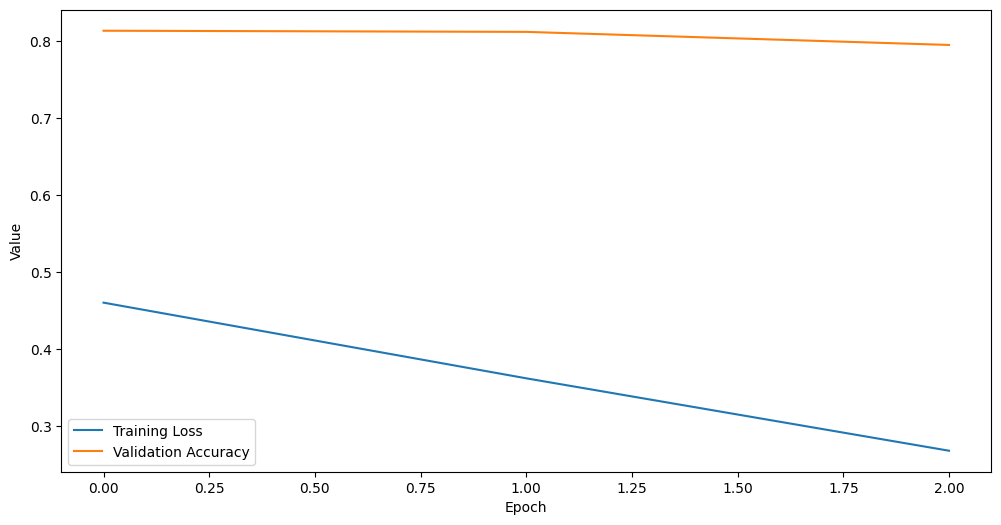

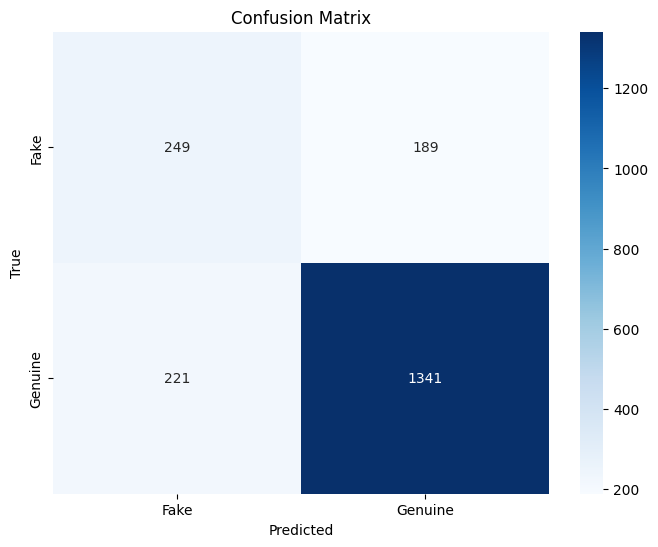

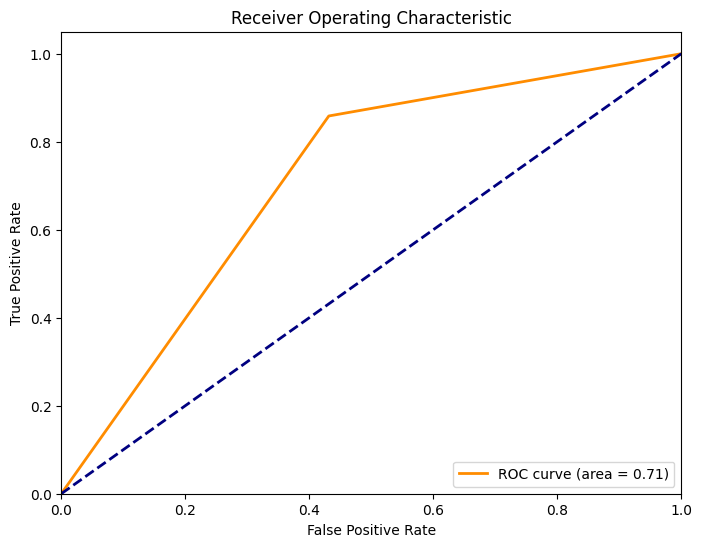

In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

# Load the dataset
df = pd.read_csv('threshold.csv', nrows=10000)
df['target'] = df['target'].map({'genuine': 1, 'fake': 0})
df['text'] = df['text'].apply(preprocess_text)

# Split the dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the text
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

# Convert to torch tensors
train_inputs = torch.tensor(train_encodings['input_ids'])
train_masks = torch.tensor(train_encodings['attention_mask'])
train_labels = torch.tensor(train_labels.values)

test_inputs = torch.tensor(test_encodings['input_ids'])
test_masks = torch.tensor(test_encodings['attention_mask'])
test_labels = torch.tensor(test_labels.values)

# Create DataLoader objects
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32, num_workers=4)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32, num_workers=4)

# Load the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function
def train_model():
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_dataloader)
    return avg_train_loss

# Evaluation function
def evaluate_model():
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, axis=1).tolist())
            true_labels.extend(b_labels.tolist())
    acc = accuracy_score(true_labels, preds)
    report = classification_report(true_labels, preds, output_dict=True)
    cm = confusion_matrix(true_labels, preds)
    return acc, report, cm, preds, true_labels

# Train and evaluate the model
train_losses = []
val_accuracies = []

for epoch in range(3):
    print(f"Epoch {epoch + 1}")
    train_loss = train_model()
    train_losses.append(train_loss)
    acc, report, cm, preds, true_labels = evaluate_model()
    val_accuracies.append(acc)
    print(f"Train loss: {train_loss}, Validation accuracy: {acc}")
    print("Classification Report:")
    print(report)

# Plot training loss and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Genuine'], yticklabels=['Fake', 'Genuine'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(true_labels, preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Save the model
# model.save_pretrained('distilbert_model')
# tokenizer.save_pretrained('distilbert_model')
